# Level 1 - Image Classification
> Three essential levels of Vision Deep Learning with PyTorch.

- toc: true 
- badges: true
- comments: true
- categories: [image classification]
- image: images/chart-preview.png

Compiled by: Ferdi Pratama

# GPU check

First, simply select "GPU" in the Accelerator drop-down in Notebook Settings
(either through the Edit menu or the command palette at cmd/ctrl-shift-P).

Then, we should test if the GPU is detected, and find out which GPU we are using.

In [0]:
!nvidia-smi

Sun Apr  5 14:09:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Overview

<!-- <img src="https://i.pinimg.com/originals/0a/76/eb/0a76eb3c95c249cdff9449af08ac4efc.png" width="640"> -->
![](https://i.pinimg.com/originals/0a/76/eb/0a76eb3c95c249cdff9449af08ac4efc.png)

Source: https://i.pinimg.com/originals/0a/76/eb/0a76eb3c95c249cdff9449af08ac4efc.png

There are two main parts
1. finetuning the model
2. predicting images

In the first part, we will:
* finetune a network to classify images of flower
* save the trained model

In the second part, we will:
* load the saved model
* use it to predict the category of new images of flower

# Finetune the model

## Import resources

In [0]:
# Pretty display for Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import Python libraries  
import json
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import copy
import time
from PIL import Image

# Import PyTorch libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch.optim import lr_scheduler

print("Using Torch ver. "+torch.__version__)

Using Torch ver. 1.4.0


## Load the dataset

Here we use the flower dataset from udacity.

In [0]:
data_dir = "/content/flower_data"
!rm -rf "{data_dir}"
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!mkdir "{data_dir}" && tar -xzf flower_data.tar.gz -C "{data_dir}"
!rm -rf "/content/flower_data.tar.gz"

## Set parameters

TODO: Explain why we need these params

In [0]:
# Stats needed to normalize ImageNet images
means = [0.485, 0.456, 0.406]
std_devs = [0.229, 0.224, 0.225]
input_size = 224

# Other transforms parameters 
down_size = 256
rotation = 30

# Determine batch size for DataLoaders
batch_size = 16

## Define data transformations

We define the function for the training, validation, and testing dataset.

In [0]:
# Define transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(rotation),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means,std_devs)]),
    'valid': transforms.Compose(
        [transforms.Resize(down_size),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize(means,std_devs)]),
    'test': transforms.Compose([
        transforms.Resize(down_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(means,std_devs)])
    }

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'valid', 'test']}
              
class_names = image_datasets['train'].classes
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Confirm the data set

First, let's check out the number of dataset we have!

In [0]:
print(dataset_sizes)
print(device)

{'train': 6552, 'valid': 818, 'test': 819}
cuda:0


We define a function to show the images contains in the first batch.
Note that the images have been resized to `input_size`.

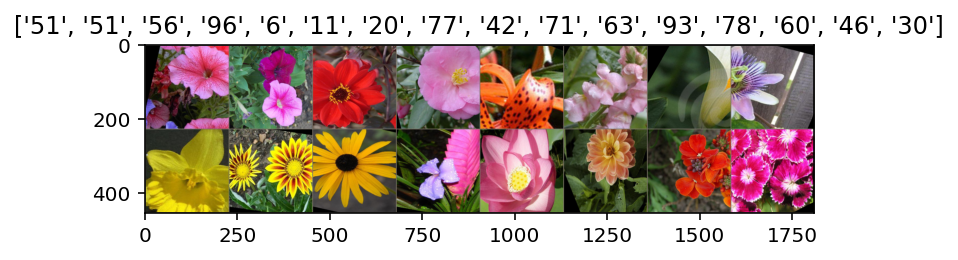

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(std_devs)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Load label mapping


At this point, we need a mapping between the numbered label and the actual names of the flowers.

TODO: add more explanation

In [0]:
# Label mapping

!wget -P "{data_dir}" https://raw.githubusercontent.com/udacity/aipnd-project/master/cat_to_name.json

with open(os.path.join(data_dir, 'cat_to_name.json'), 'r') as f:
    cat_to_name = json.load(f)

--2020-04-05 12:33:05--  https://raw.githubusercontent.com/udacity/aipnd-project/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘/content/flower_data/cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2020-04-05 12:33:05 (63.8 MB/s) - ‘/content/flower_data/cat_to_name.json’ saved [2218/2218]



In [0]:
# Test the data loader
images, labels = next(iter(dataloaders['train']))
images.size()

images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))

label: 65, class: 66, name: osteospermum


## Build new classifier layers

The classifier layers of the pre-trained network must be replaced with a classifier that fits the parameters of our flower-image classification problem.

Before building and replacing the network classifier, I will exclude all pre-trained parameters from gradient computation.

The input in the new classifier must match the output of the pre-trained network (25,088). The output of the classifier will be the set of image categories in the flowers datasets (102).

TODO: add more explanation

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    # Freeze updating of pre-trained parameters
    # I decided to make sure I only trained the classifier parameters here 
    # while having feature parameters frozen. 
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. 
    # Each of these variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg19":
        """ VGG19
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "vgg11":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_name = 'vgg19'
num_classes = len(class_names)
feature_extract = True

# Initialize the model for this run
model_conv, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_conv)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

#### Tips

To find out more about other predefined models from PyTorch, run the following command and refer to this documentation:

[https://pytorch.org/docs/stable/torchvision/models.html](https://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
dir(models)

## Train the classifier and track running performance

The two main tasks in this section are the following:

1. Train the classifier layers using backpropagation and the pre-trained network to get the features.
2. Track the loss and accuracy on the validation set to determine the best hyper-parameters.

Train the classifier layers

I start by instantiating the necessary classes for the optimization component of network training.

First, the loss function will be a Negative Log Likelihood (torch.nn.NLLLoss)

Second, the optimization method will be the Adam algorithm (torch.optim.Adam).


In [0]:
# Instantiate loss function
loss_function = nn.NLLLoss()

# Instantiate optimization algorithm 
learning_rate = 0.0001
optimizer = optim.Adam(model_conv.classifier.parameters(), 
                       lr=learning_rate)

# Enable CUDA: use GPUs for model computation
if torch.cuda.is_available():
    model_conv.to('cuda')
    
# Now we define params for the training loop

# Epochs: number of iterations over the entire training dataset
epochs = 15
# Number of iterations between printing loss and accuracy 
print_steps = 30

Now we can define a function for training the model.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Create the optimizer

Now that the model structure is correct, the final step for finetuning and feature extracting is to create an optimizer that only updates the desired parameters. Recall that after loading the pretrained model, but before reshaping, if feature_extract=True we manually set all of the parameter’s `.requires_grad` attributes to False. Then the reinitialized layer’s parameters have `.requires_grad=True` by default. So now we know that all parameters that have `.requires_grad=True` should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.

In [0]:
model_conv = model_conv.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_conv.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_conv.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_conv.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Now we are ready to train our model!

In [0]:
model_conv = train_model(model_conv, 
                         criterion, 
                         optimizer_conv, 
                         exp_lr_scheduler,
                         num_epochs=3
                        )

Epoch 0/2
----------
train Loss: 3.0470 Acc: 0.3307
valid Loss: 1.8235 Acc: 0.6015

Epoch 1/2
----------
train Loss: 1.9147 Acc: 0.5449
valid Loss: 1.3099 Acc: 0.6980

Epoch 2/2
----------
train Loss: 1.5916 Acc: 0.6090
valid Loss: 1.0807 Acc: 0.7494

Training complete in 3m 22s
Best val Acc: 0.749389


## Calculate Accuracy

We can also define a function to calculate the accuracy.

In [0]:
def calc_accuracy(mode='test'):
    # Initialize validation counters
    cnt_correct = 0
    cnt_total = 0

    # no_grad() prevents tracking history (and using memory)
    with torch.no_grad(): 

        # Iterate over the entire validation dataset
        for input_images, labels in dataloaders[mode]:

            # Enable CUDA: use GPUs for model computation
            if torch.cuda.is_available():
                input_images, labels = input_images.to('cuda'), labels.to('cuda')

            # Make predictions 
            outputs = model_conv(input_images)
            _, predicted = torch.max(outputs.data, 1)

            # Count total and correct predictions
            cnt_total += labels.size(0)
            cnt_correct += (predicted == labels).sum().item()
            
    print(mode + ' accuracy ({0:d} images): {1:.1%}'
          .format(cnt_total, cnt_correct / cnt_total))

In [0]:
calc_accuracy('valid')
calc_accuracy('test')

valid accuracy (818 images): 74.9%
test accuracy (819 images): 70.9%


In [0]:
calc_accuracy('train')

train accuracy (6552 images): 72.7%


## Visualized model

TODO: add

In [0]:
def visualize_model(model, num_images=6, mode='test'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[mode]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
#                 ax.axis([0, 224, 0,224])
                num_label = class_names[preds[j]]
                str_label = cat_to_name[num_label]
                ax.set_title('{}'.format(str_label))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
#     out = utils.make_grid(inputs)
#     imshow(out)

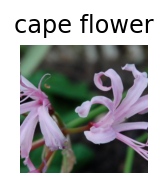

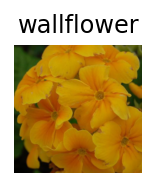

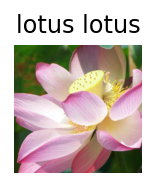

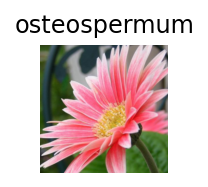

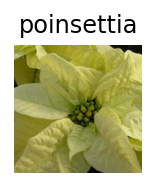

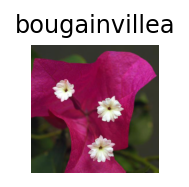

In [0]:
visualize_model(model_conv, mode='test')

## Save the trained network

Now that the network is trained, I save the model so it can be loaded later to make predictions.

In order to save the model allowing for the option to keep training it later, I also save the necessary training parameters: number of epochs and the optimizer state.

In [0]:
# Save the mapping of the flower labels (1-102) to array indices (0-101)
model_conv.class_to_idx = image_datasets['train'].class_to_idx

# Create dictionary with needed components to rebuild model
checkpoint = {
    'model': model_conv,
    'epochs': epochs,
    'optimizer_state': optimizer.state_dict,
    'labels_to_flower_names': cat_to_name
    }

# Save checkpoint
torch.save(checkpoint, 'checkpoint_04-05-2020.pth')

# Predict images based on the model

In [0]:
# Stats needed to normalize ImageNet images
ImageNet = {
    'means' : np.array([0.485, 0.456, 0.406]),
    'std_devs' : np.array([0.229, 0.224, 0.225]),
    'short_ax_max' : 255,
    'resize' : 224
    }

In [0]:
# Process a PIL image for use in a PyTorch model
def process_image(pil_image, image_reqs=ImageNet):
    """Scale, crop, and normalize a PIL image for a PyTorch model.
    Returns a NumPy array
    
    Args:
       pil_image (PIL image): Input image for a prediction task 
       image_reqs (dict): Image stats needed so image matches model reqs
    Returns:
        NumPy array
    
    """
    # Resize image so that shortest side is 256 pixels, keeping ratio
    img_size = pil_image.size
    ratio = max(img_size) / min(img_size)
    new_size = [0, 0]
    short = img_size.index(min(img_size))
    long = 1 - short 
    new_size[short] = image_reqs['short_ax_max']
    new_size[long] = int(image_reqs['short_ax_max'] * ratio)
    pil_image = pil_image.resize(size=tuple(new_size))
    
    # Crop out the center 224x224 portion of the image
    gap_x = int((new_size[0] - image_reqs['resize']) / 2)
    gap_y = int((new_size[1] - image_reqs['resize']) / 2)
    crop_box = (gap_x, gap_y, gap_x + image_reqs['resize'], 
                gap_y + image_reqs['resize']) 
    pil_image = pil_image.crop(box=crop_box)
    
    # Re-encode image color channels
    np_image = np.array(pil_image) / 255
    
    # Normalize image accordingly to the same statistics used to train 
    norm_image = (np_image - image_reqs['means']) / image_reqs['std_devs']
    
    # Reorder dimensions of NumPy array so it matches PyTorch's input
    norm_image = norm_image.transpose((2, 0, 1))
    
    return norm_image

## Deploy trained network for predictions

Now that images are processed to the expected PyTorch format, they can be passed into a function that uses the trained model to make predictions.

A common practice is to predict the top 5, or so, most probable classes (usually called top-$K$). The function below, predict(), takes the image filepath and the trained model — and returns the ordered lists of the most likely classes and their corresponding probabilities.

In [0]:
# Load a flower image and make a prediction of the top-K classes
def predict(img_filepath, model, topk=5):
    ''' Predict the top-K classes of an image using a trained 
    deep learning model.
    
    Args:
       img_filepath (str): Input image for the prediction task 
       model (torchvision.models): Trained deep learning model
       topk (int): Number of top most likely predictions
    Returns:
        top_probs (list)
        classes (list)
    
    '''
    # Open PIL image
    pil_image = Image.open(img_filepath)
    # Scale, crop, normalize PIL image
    np_image = process_image(pil_image, image_reqs=ImageNet) 
    
    # Resize NumPy array to match dataloader output
    np_image = np.resize(np_image,(1, 3, 224, 224))
    # Covert NumPy array to PyTorch tensor
    img_tensor = torch.from_numpy(np_image).type(torch.FloatTensor)

    # Enable CUDA: use GPUs for model computation
    if torch.cuda.is_available():
        img_tensor = img_tensor.to('cuda')
    
    # Run model in evaluation mode 
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Convert softmax output to probabilities
    probs = torch.exp(outputs.data)
    
    # Find top-k probabilities and indices 
    top_probs, indices = torch.topk(probs, dim=1, k=topk)
    
    # Convert PyTorch tensors to lists
    top_probs, indices = top_probs.to('cpu').numpy(), indices.to('cpu').numpy()
    top_probs, indices = top_probs[0].tolist(), indices[0].tolist()
    
    # Find the class using the indices (reverse dictionary first)
    idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return top_probs, classes

## Sanity check: Make a flower category prediction


In this final section we will check whether the predictions that come out of the image classification tool make sense.

This will not be a comprehensive test, but just a sanity check to screen for obvious bugs and errors.

The main steps in this prediction test are the following:

1. Choose a flower image, of known category, from the test set. And run the image through the trained network using the predict() function.

2. Get the flower names (in words) from the checkpoint dictionary, for the chosen test flower and the predicted top-$K$ classes.

3. Write the function imshow(), which takes the output of the process_image() function and re-processes the array to be plotted with matplotlib. This will let us visualize the input image as seen by the trained model.

4. Display the test flower image along with a bar chart of the top-5 predicted categories.

Choose test image and run through the model.

In [0]:
# Choose a flower category and individual image for prediction example
test_class = '74'
pathname = data_dir+'/test/'+test_class+"/"

import random
rand_file = random.choice(os.listdir(pathname))
filepath = pathname+rand_file
# print(filepath)

# Run predict() to get model predictions: top-k classes and probabilities 
probs, classes = predict(filepath, model_conv, topk=5)

## Get flower names from checkpoint dictionary

In [0]:
# Get the flower-category names from the saved checkpoint
flower_names = checkpoint['labels_to_flower_names']
test_flower_name = flower_names[test_class]
top_k_names = [flower_names[key] for key in classes]

In [0]:
def imshow(image, ax=None, title=None, image_reqs=ImageNet):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = image_reqs['means']
    std = image_reqs['std_devs']
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

In [0]:
# Create figure and axes 
fig, (flower, prob_bars) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

# Render the flower image
imshow(image=process_image(Image.open(filepath)), ax=flower)

flower.set_title('Test flower category:\n— {} —'.format(test_flower_name), 
                 fontsize=16)

# Make barchart of top-k probabilities 
index = np.arange(len(classes))[::-1]
prob_bars.barh(index, probs, tick_label=top_k_names, align='center')
prob_bars.set_title('Model prediction', fontsize=14)
prob_bars.set_xlabel('Probability', fontsize=12)
prob_bars.set_ylabel('Top-K classes', fontsize=12)

# Plot the final figure
fig.tight_layout()

# Conclusion


TODO: add conclusion

# Reference

This notebook is a compilation of multiple information taken from the following different sources.
Credits go to their respective authors.

TODO: add more reference

* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
* https://cs231n.github.io/transfer-learning/
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://medium.com/datadriveninvestor/creating-a-pytorch-image-classifier-da9db139ba80
* https://github.com/jclh/image-classifier-PyTorch/blob/master/flower-classifier-PyTorch.ipynb